In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import socket, struct
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
pd.set_option('display.max_columns', 500)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
%pip install pyarrow
%pip install fastparquet

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Data processing

In [152]:
#df = pd.read_parquet('merged_dataset.gzip')
df = pd.read_parquet('subset.gzip')

In [2]:
df_subset = pd.concat([df[df.Label == 0].sample(300000), df[df.Label == 1].sample(300000)])
df_subset.to_parquet('subset.gzip')
df = df_subset

NameError: name 'df' is not defined

In [153]:
def ip2long(ip):
    """
    Convert an IP string to long
    """
    packedIP = socket.inet_aton(ip)
    return struct.unpack("!L", packedIP)[0]

# Convert IPs to numbers
df.loc[:,'IPV4_SRC_ADDR'] = df['IPV4_SRC_ADDR'].copy().apply(ip2long)
df.loc[:,'IPV4_DST_ADDR'] = df['IPV4_DST_ADDR'].copy().apply(ip2long)
df.head(2)

IPV4_SRC_ADDR  L4_SRC_PORT  IPV4_DST_ADDR  L4_DST_PORT  PROTOCOL  \
589978      3076059454        34370      175300823         8728         6   
1281252      175301068        52037      175305073           53        17   

         IN_BYTES  IN_PKTS  OUT_BYTES  OUT_PKTS  TCP_FLAGS  \
589978         52        1         40         1         22   
1281252        73        1        349         1          0   

         FLOW_DURATION_MILLISECONDS  MIN_IP_PKT_LEN  MAX_IP_PKT_LEN  \
589978                            1               0               0   
1281252                          35               0               0   

        SRC_TO_DST_SECOND_BYTES DST_TO_SRC_SECOND_BYTES  \
589978                       52                      40   
1281252                      73                     349   

         RETRANSMITTED_IN_BYTES  RETRANSMITTED_IN_PKTS  \
589978                        0                      0   
1281252                       0                      0   

         RETRANSMITTED_OUT_BYTES  RETRANSMITTED_OUT_PKTS  TCP_WIN_MAX_IN  \
589978                         0                       0            8192   
1281252                        0                       0               0   

         TCP_WIN_MAX_OUT  Label  Attack L7_PROTO_NAME PROTOCOL_MAP  
589978                 0      0  Benign       Unknown          tcp  
1281252                0      0  Benign    DNS.Google          udp

In [154]:
# Remove rows with NaN Labels
df = df[df['L7_PROTO_NAME'].notna()]
len(df[df.Label == 0]), len(df[df.Label == 1]), df.Label.isna().sum()

(299984, 297239, 0)

In [155]:
def spb_to_mean(x):
    vals = x.split(',')
    vals = list(filter(lambda v: v != '', vals))
    vals = [int(float(x)) for x in vals]
    
    if len(vals) == 0: return 0
    
    return np.asarray(vals, dtype=np.float64).mean()

def spb_to_total(x):
    vals = x.split(',')
    vals = list(filter(lambda v: v != '', vals))
    vals = [int(float(x)) for x in vals]
    
    return np.asarray(vals, dtype=np.float64).sum()

df['DST_TO_SRC_SECOND_BYTES_MEAN'] = df.DST_TO_SRC_SECOND_BYTES.apply(spb_to_mean)
df['DST_TO_SRC_SECOND_BYTES_TOTAL'] = df.DST_TO_SRC_SECOND_BYTES.apply(spb_to_total)
df['SRC_TO_DST_SECOND_BYTES_MEAN'] = df.SRC_TO_DST_SECOND_BYTES.apply(spb_to_mean)
df['SRC_TO_DST_SECOND_BYTES_TOTAL'] = df.SRC_TO_DST_SECOND_BYTES.apply(spb_to_total)

In [156]:
l7_proto_encoder = LabelEncoder()
df['L7_PROTO_NAME'] = l7_proto_encoder.fit_transform(df['L7_PROTO_NAME'])

In [157]:
attack_encoder = LabelEncoder()
df['AttackEnc'] = attack_encoder.fit_transform(df.Attack)

In [158]:
df = df.drop(['DST_TO_SRC_SECOND_BYTES', 'SRC_TO_DST_SECOND_BYTES'], axis=1)

In [28]:
np.array(df.DST_TO_SRC_SECOND_BYTES_MEAN).std()

21684586533.038048

<AxesSubplot:>

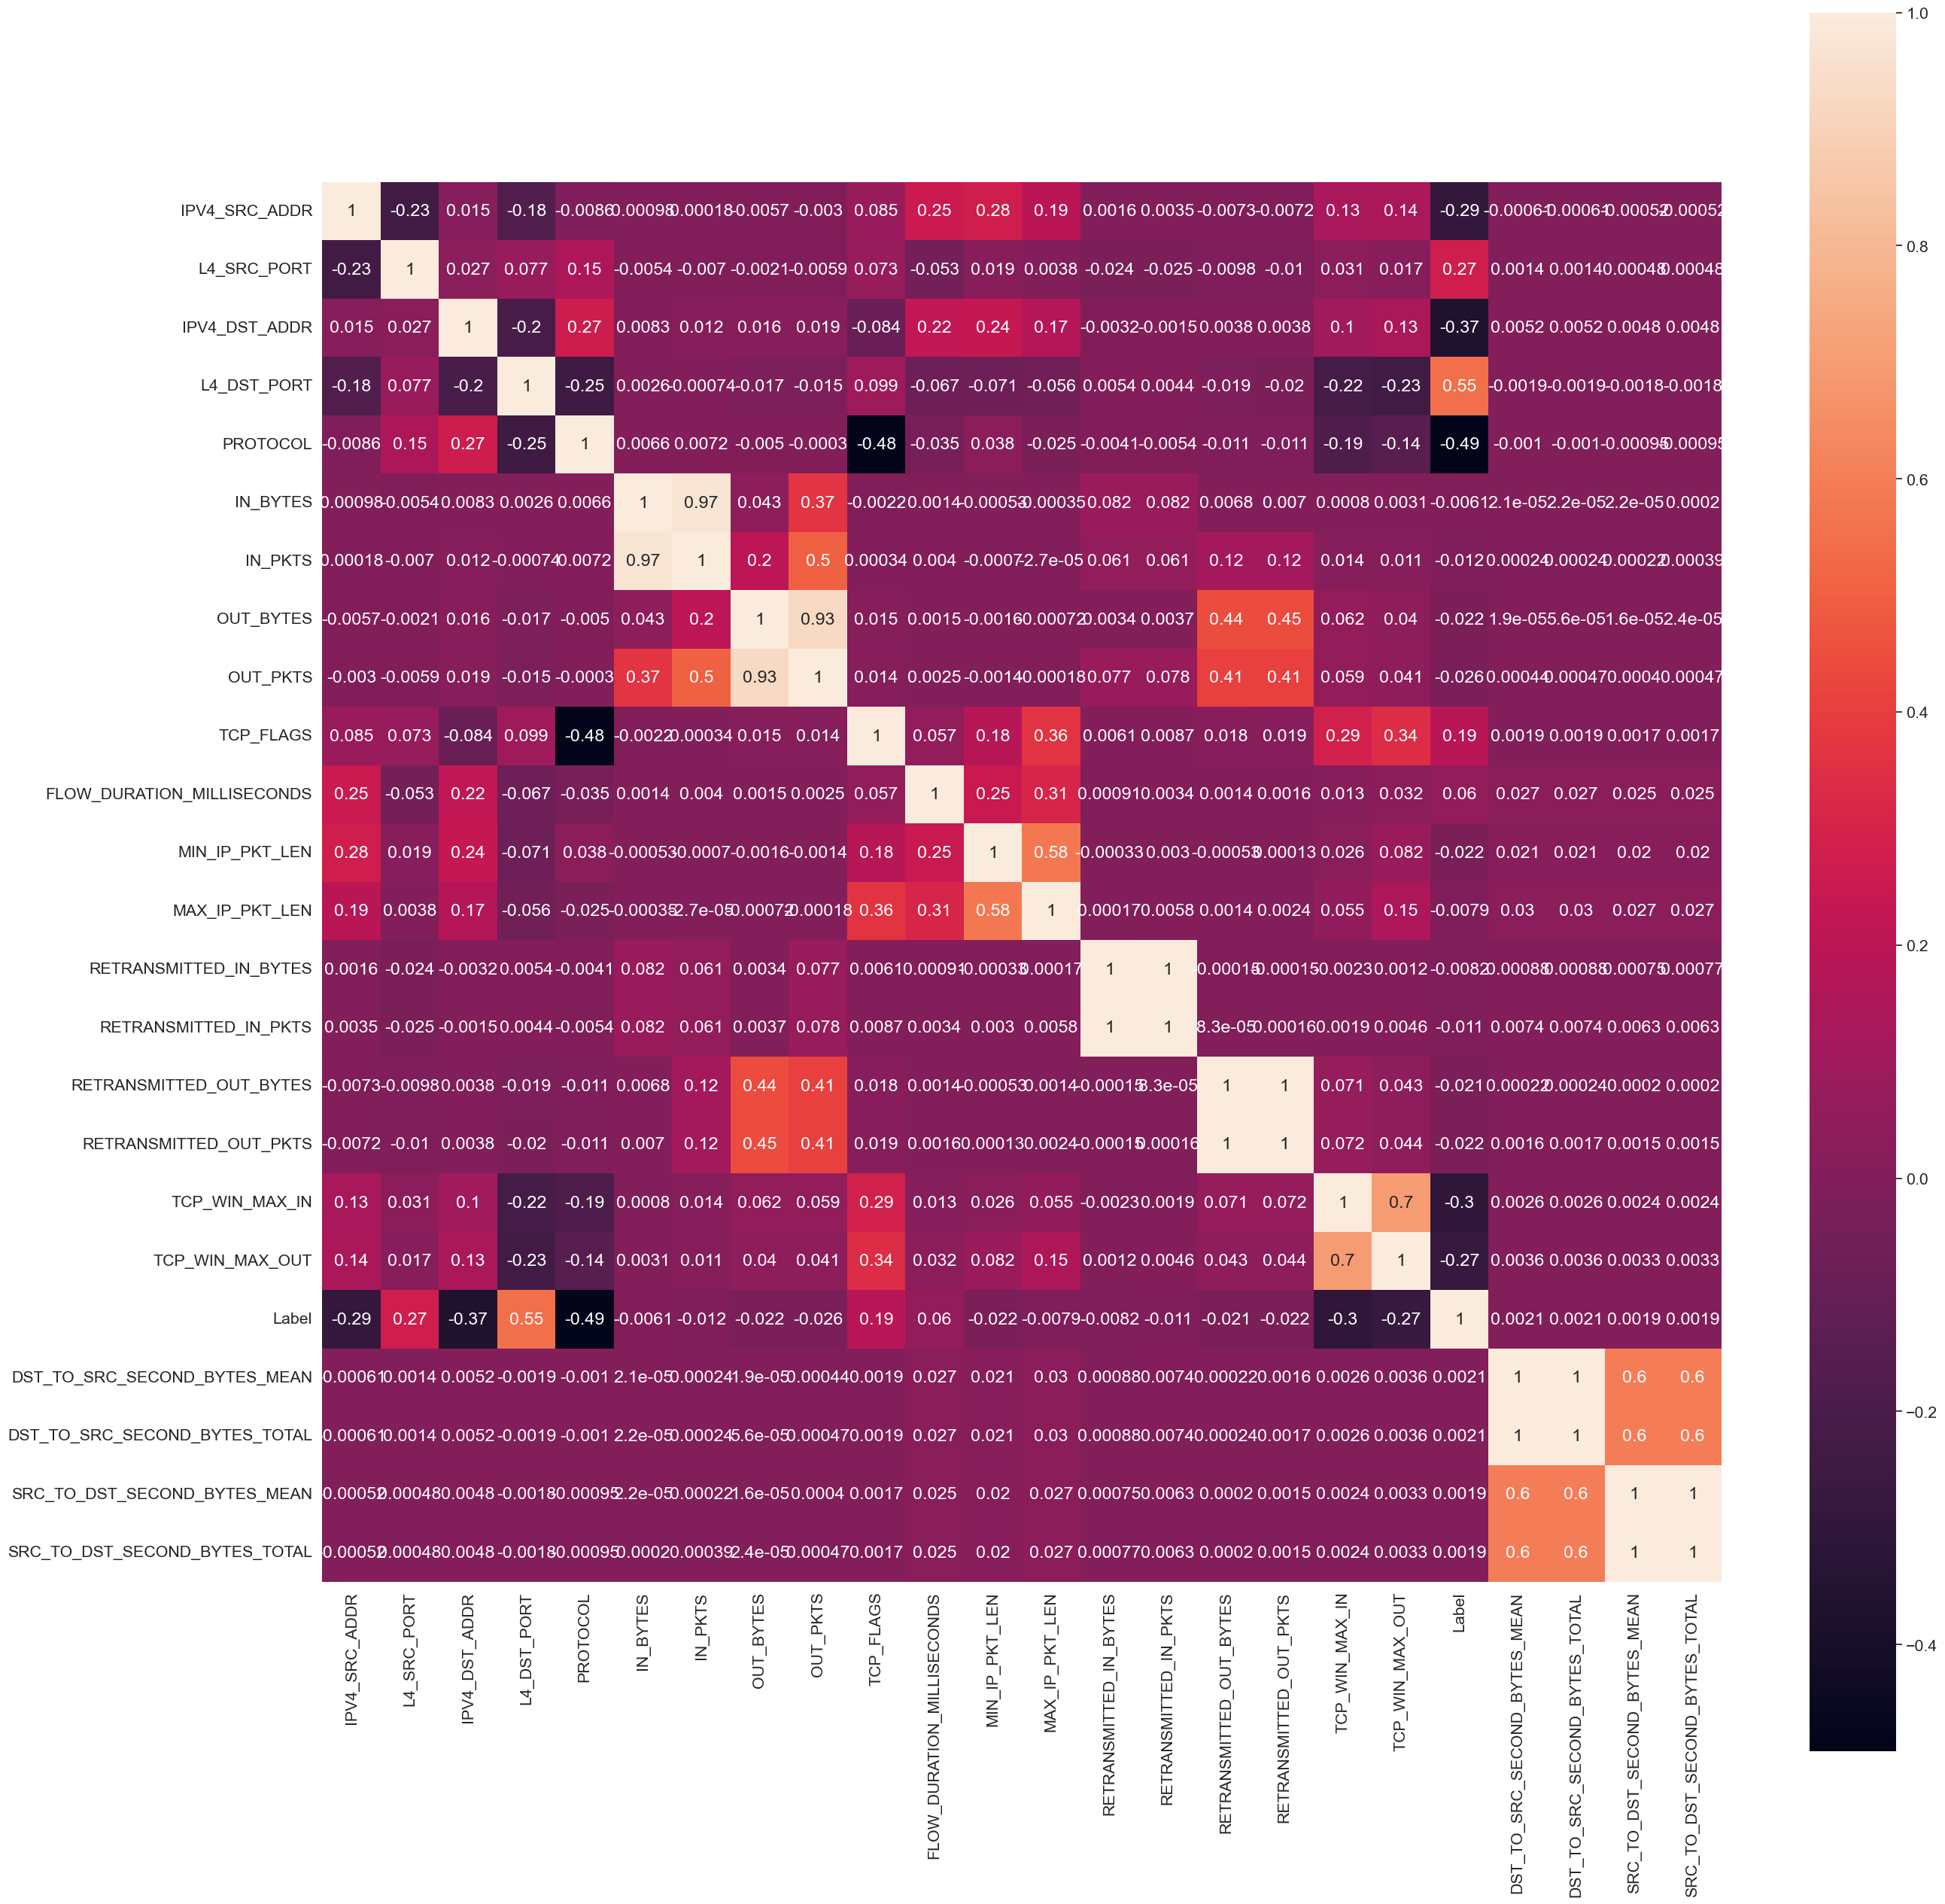

In [28]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(30, 30))
#plt.legend(title='Correlation Matrix', fontsize=20)
sns.set(font_scale=1.4)
sns.heatmap(corr, square=True, ax=ax, annot=True)

<AxesSubplot:xlabel='TCP_WIN_MAX_IN', ylabel='TCP_WIN_MAX_OUT'>

/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


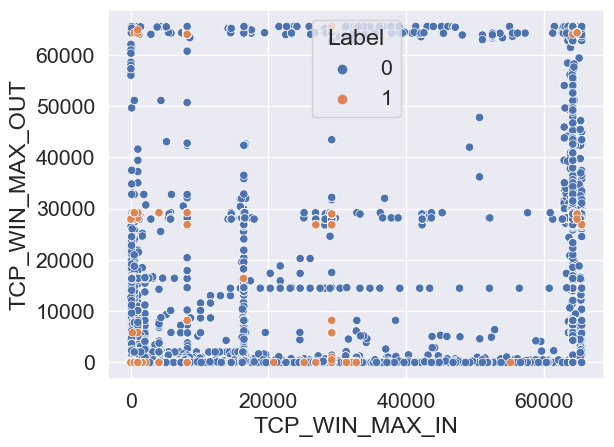

In [31]:
sns.scatterplot(data=df, x="TCP_WIN_MAX_IN", y="TCP_WIN_MAX_OUT", hue="Label")

<AxesSubplot:xlabel='TCP_WIN_MAX_IN', ylabel='IN_BYTES'>

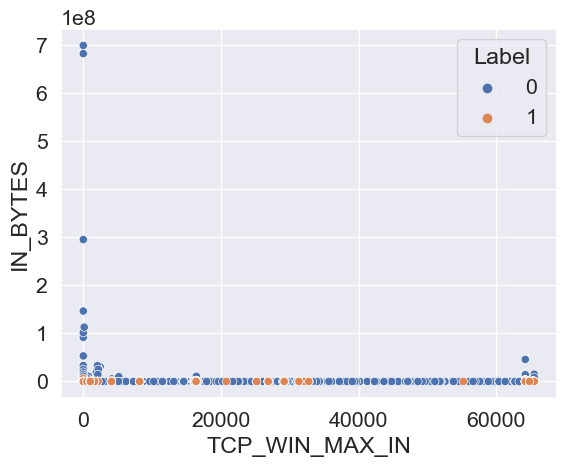

In [32]:
sns.scatterplot(data=df, x="TCP_WIN_MAX_IN", y="IN_BYTES", hue="Label")

<AxesSubplot:xlabel='IPV4_SRC_ADDR', ylabel='L4_DST_PORT'>

/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


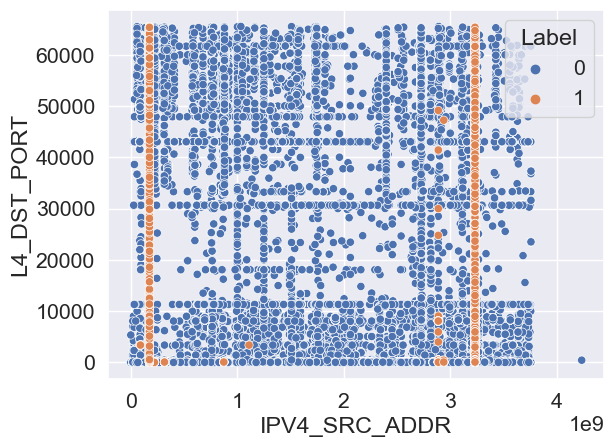

In [9]:
sns.scatterplot(data=df, x="IPV4_SRC_ADDR", y="L4_DST_PORT", hue="Label")

<AxesSubplot:xlabel='IPV4_DST_ADDR', ylabel='L4_DST_PORT'>

/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


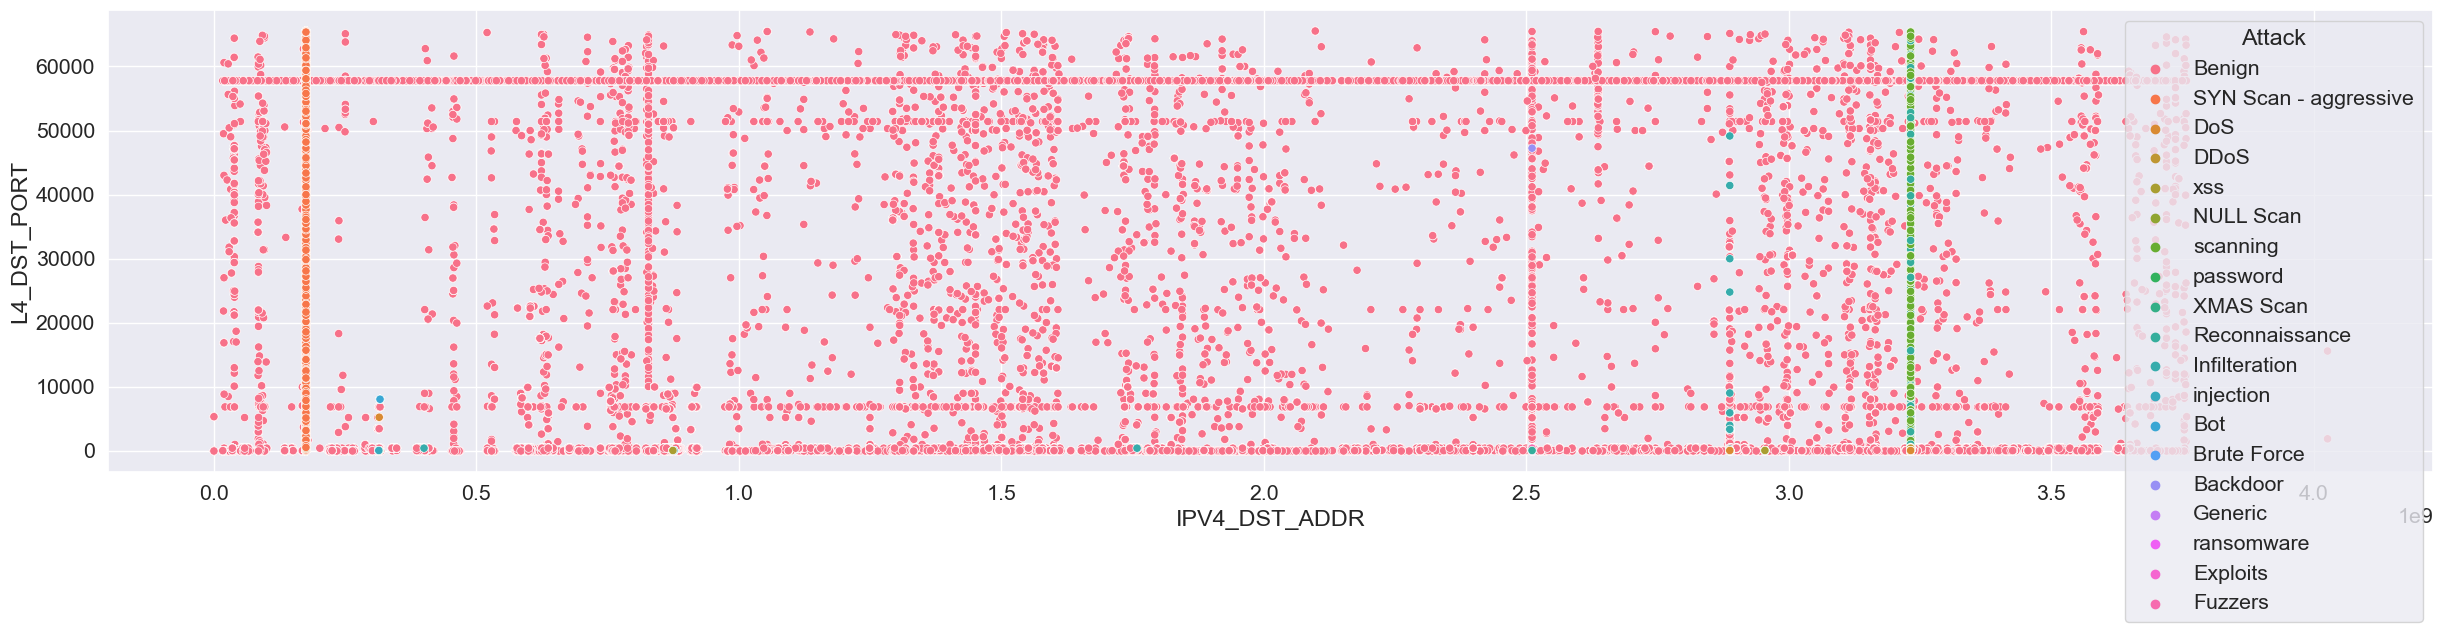

In [13]:
fig, ax = plt.subplots(figsize=(30, 6))
sns.scatterplot(data=df, x="IPV4_DST_ADDR", y="L4_DST_PORT", hue="Attack", ax=ax)



<AxesSubplot:xlabel='IPV4_DST_ADDR', ylabel='L4_SRC_PORT'>

/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


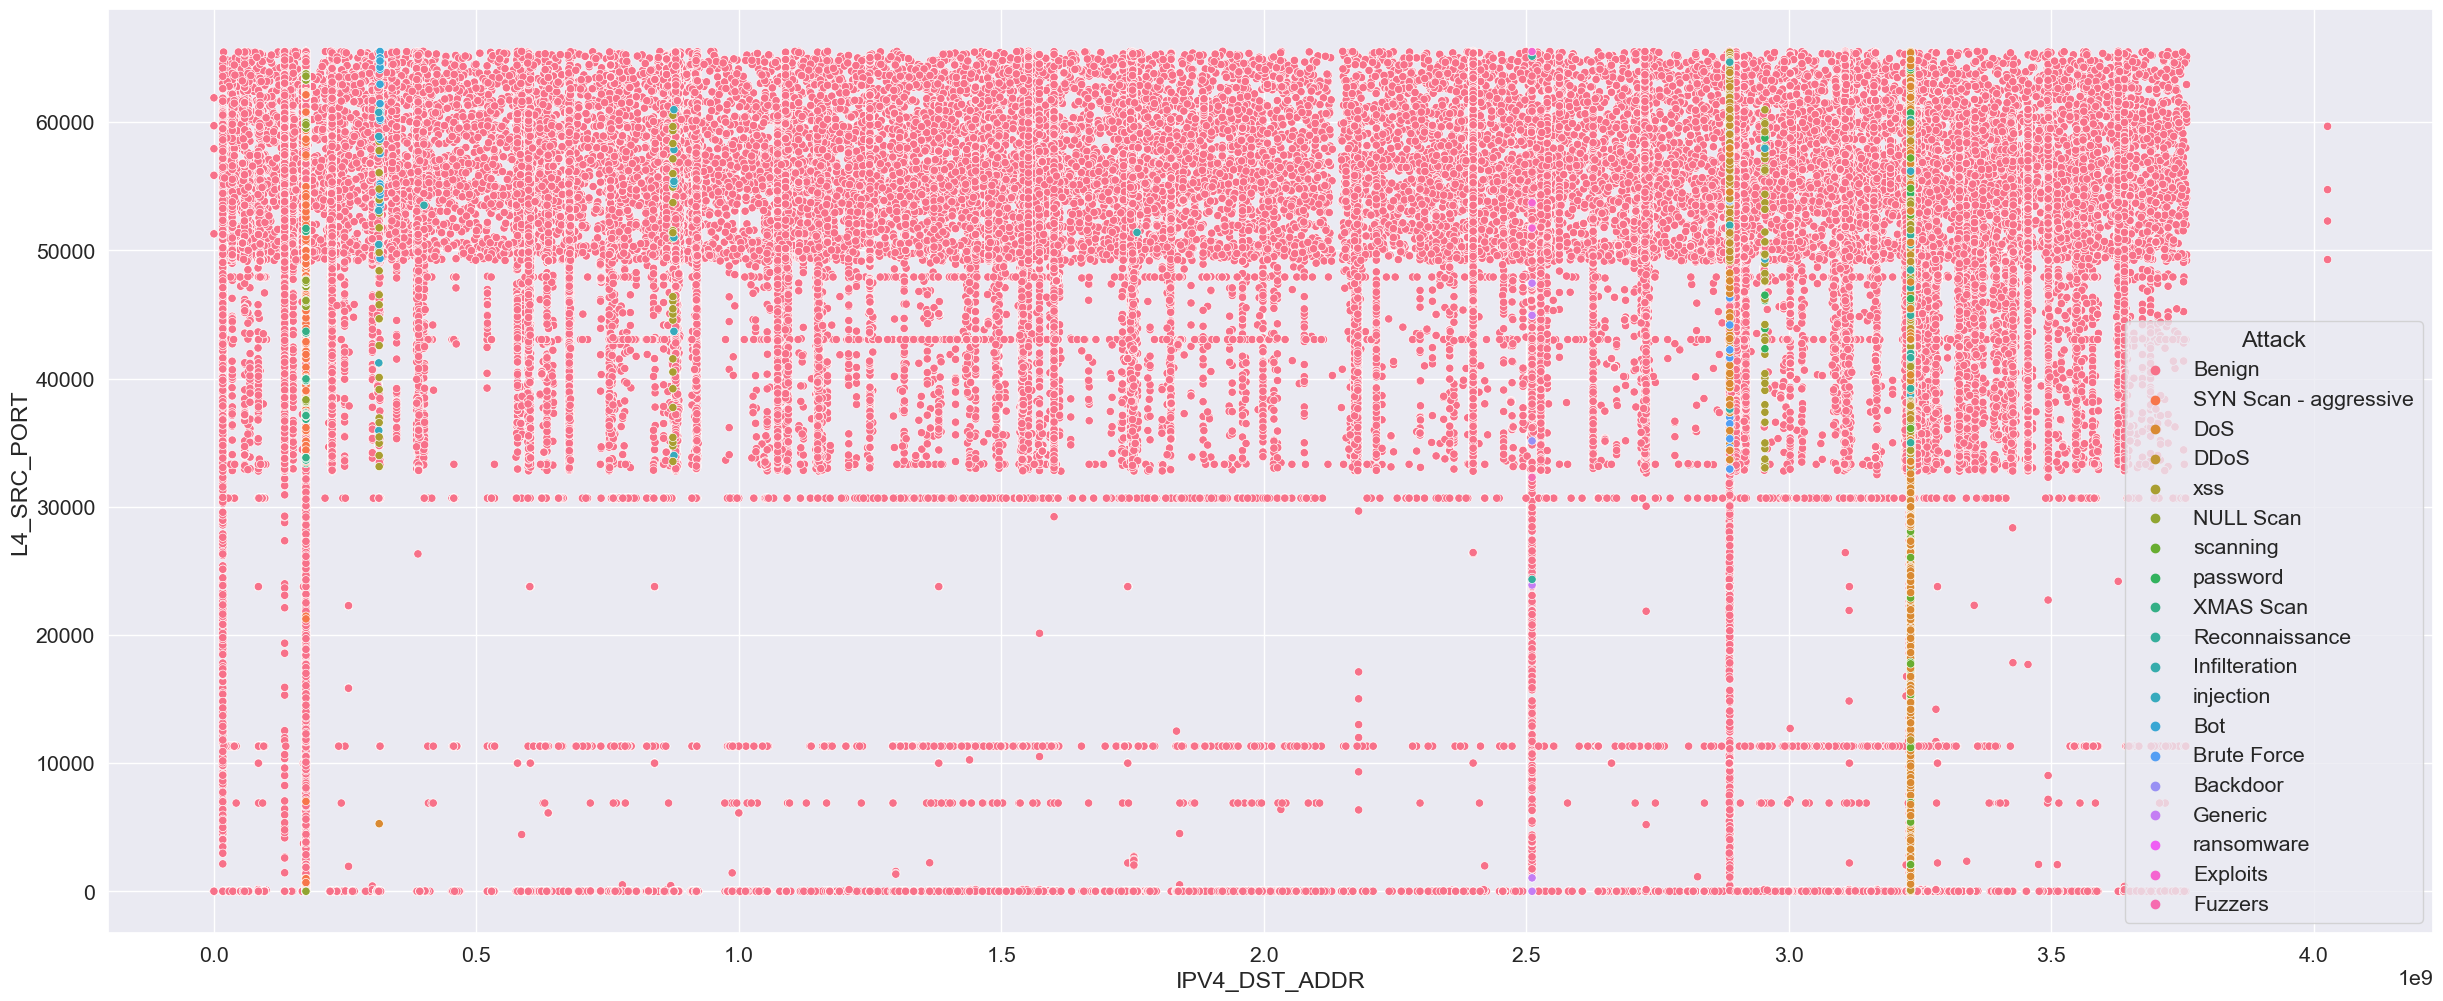

In [15]:
fig, ax = plt.subplots(figsize=(30, 12))
sns.scatterplot(data=df, x="IPV4_DST_ADDR", y="L4_SRC_PORT", hue="Attack", ax=ax)

<AxesSubplot:xlabel='L4_SRC_PORT', ylabel='L4_DST_PORT'>

/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


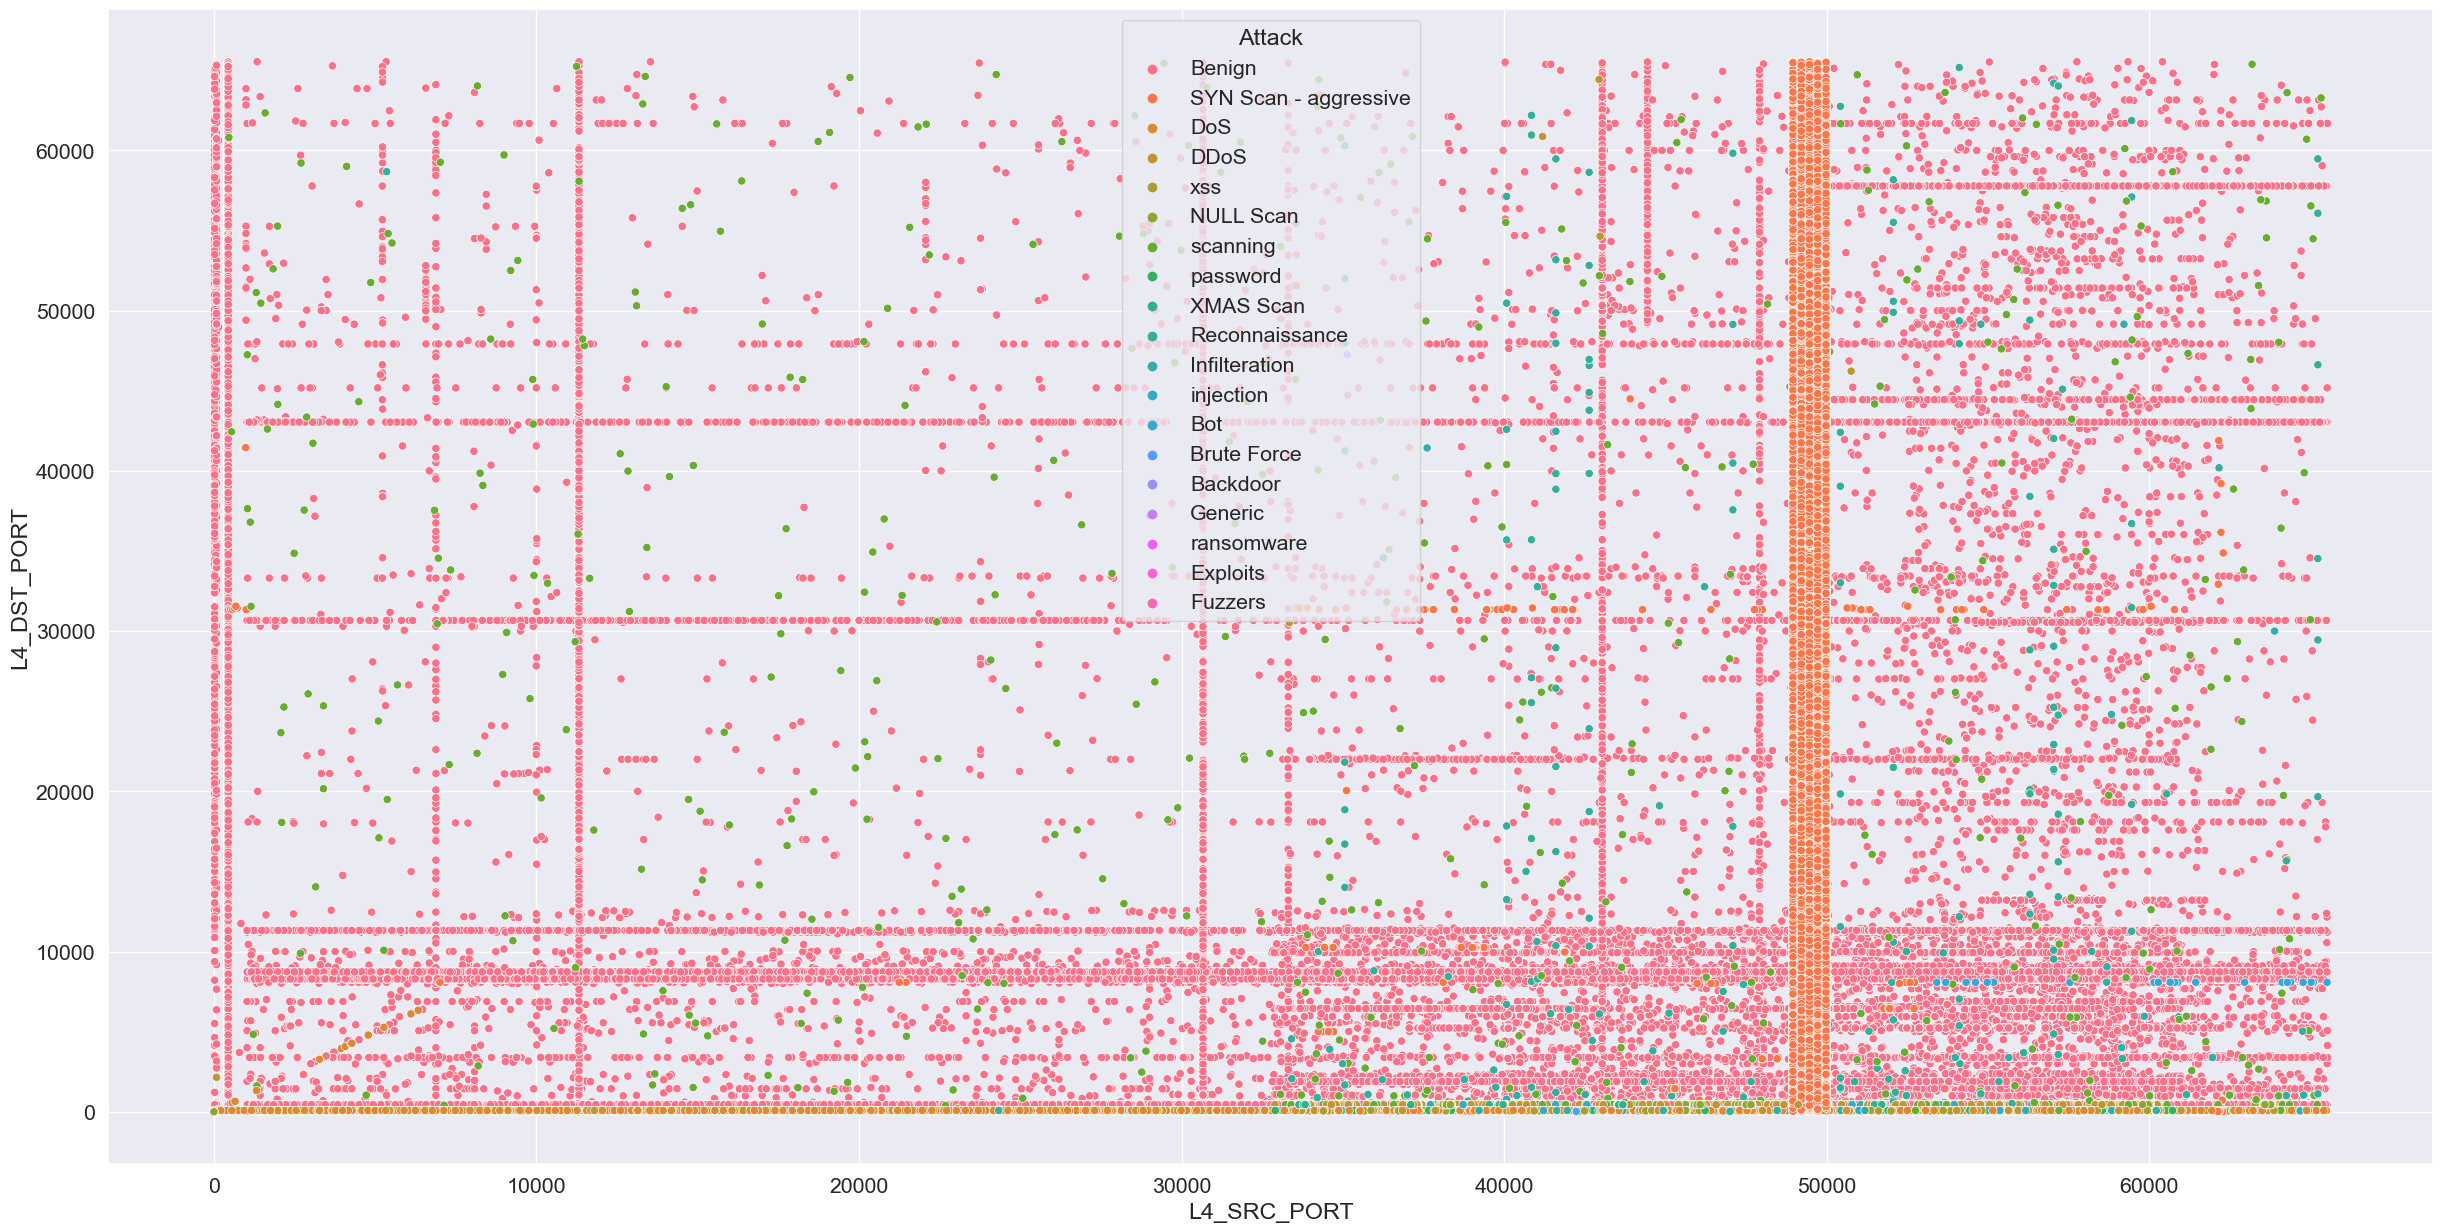

In [19]:
fig, ax = plt.subplots(figsize=(30, 15))
sns.scatterplot(data=df, x="L4_SRC_PORT", y="L4_DST_PORT", hue="Attack", ax=ax)

<AxesSubplot:xlabel='IN_BYTES', ylabel='OUT_BYTES'>

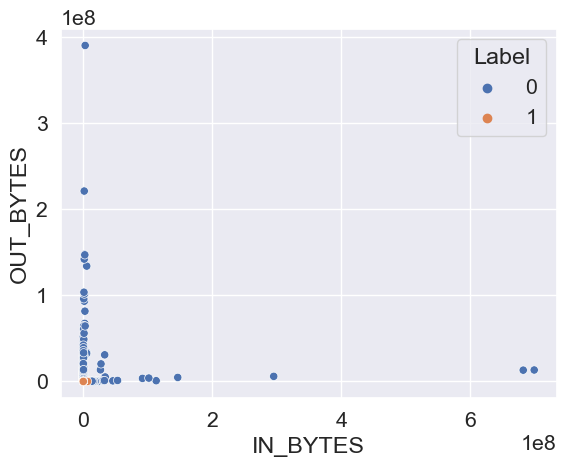

In [20]:
sns.scatterplot(data=df, x="IN_BYTES", y="OUT_BYTES", hue="Label")

In [24]:
df.PROTOCOL.describe()

count    597223.000000
mean          8.402314
std           4.843903
min           1.000000
25%           6.000000
50%           6.000000
75%           6.000000
max         177.000000
Name: PROTOCOL, dtype: float64

<AxesSubplot:xlabel='PROTOCOL', ylabel='Count'>

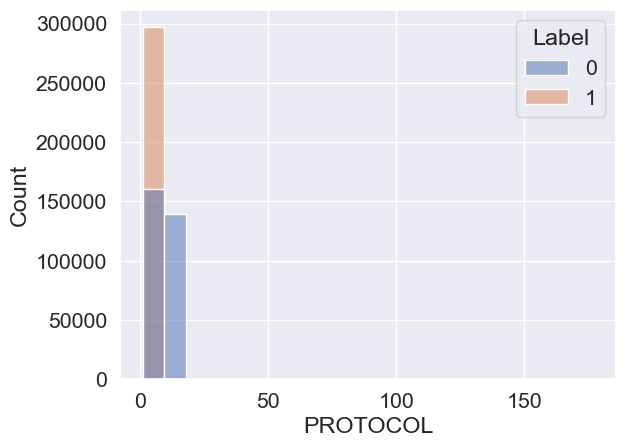

In [22]:
sns.histplot(data=df, x="PROTOCOL", hue="Label")

### Ouliers

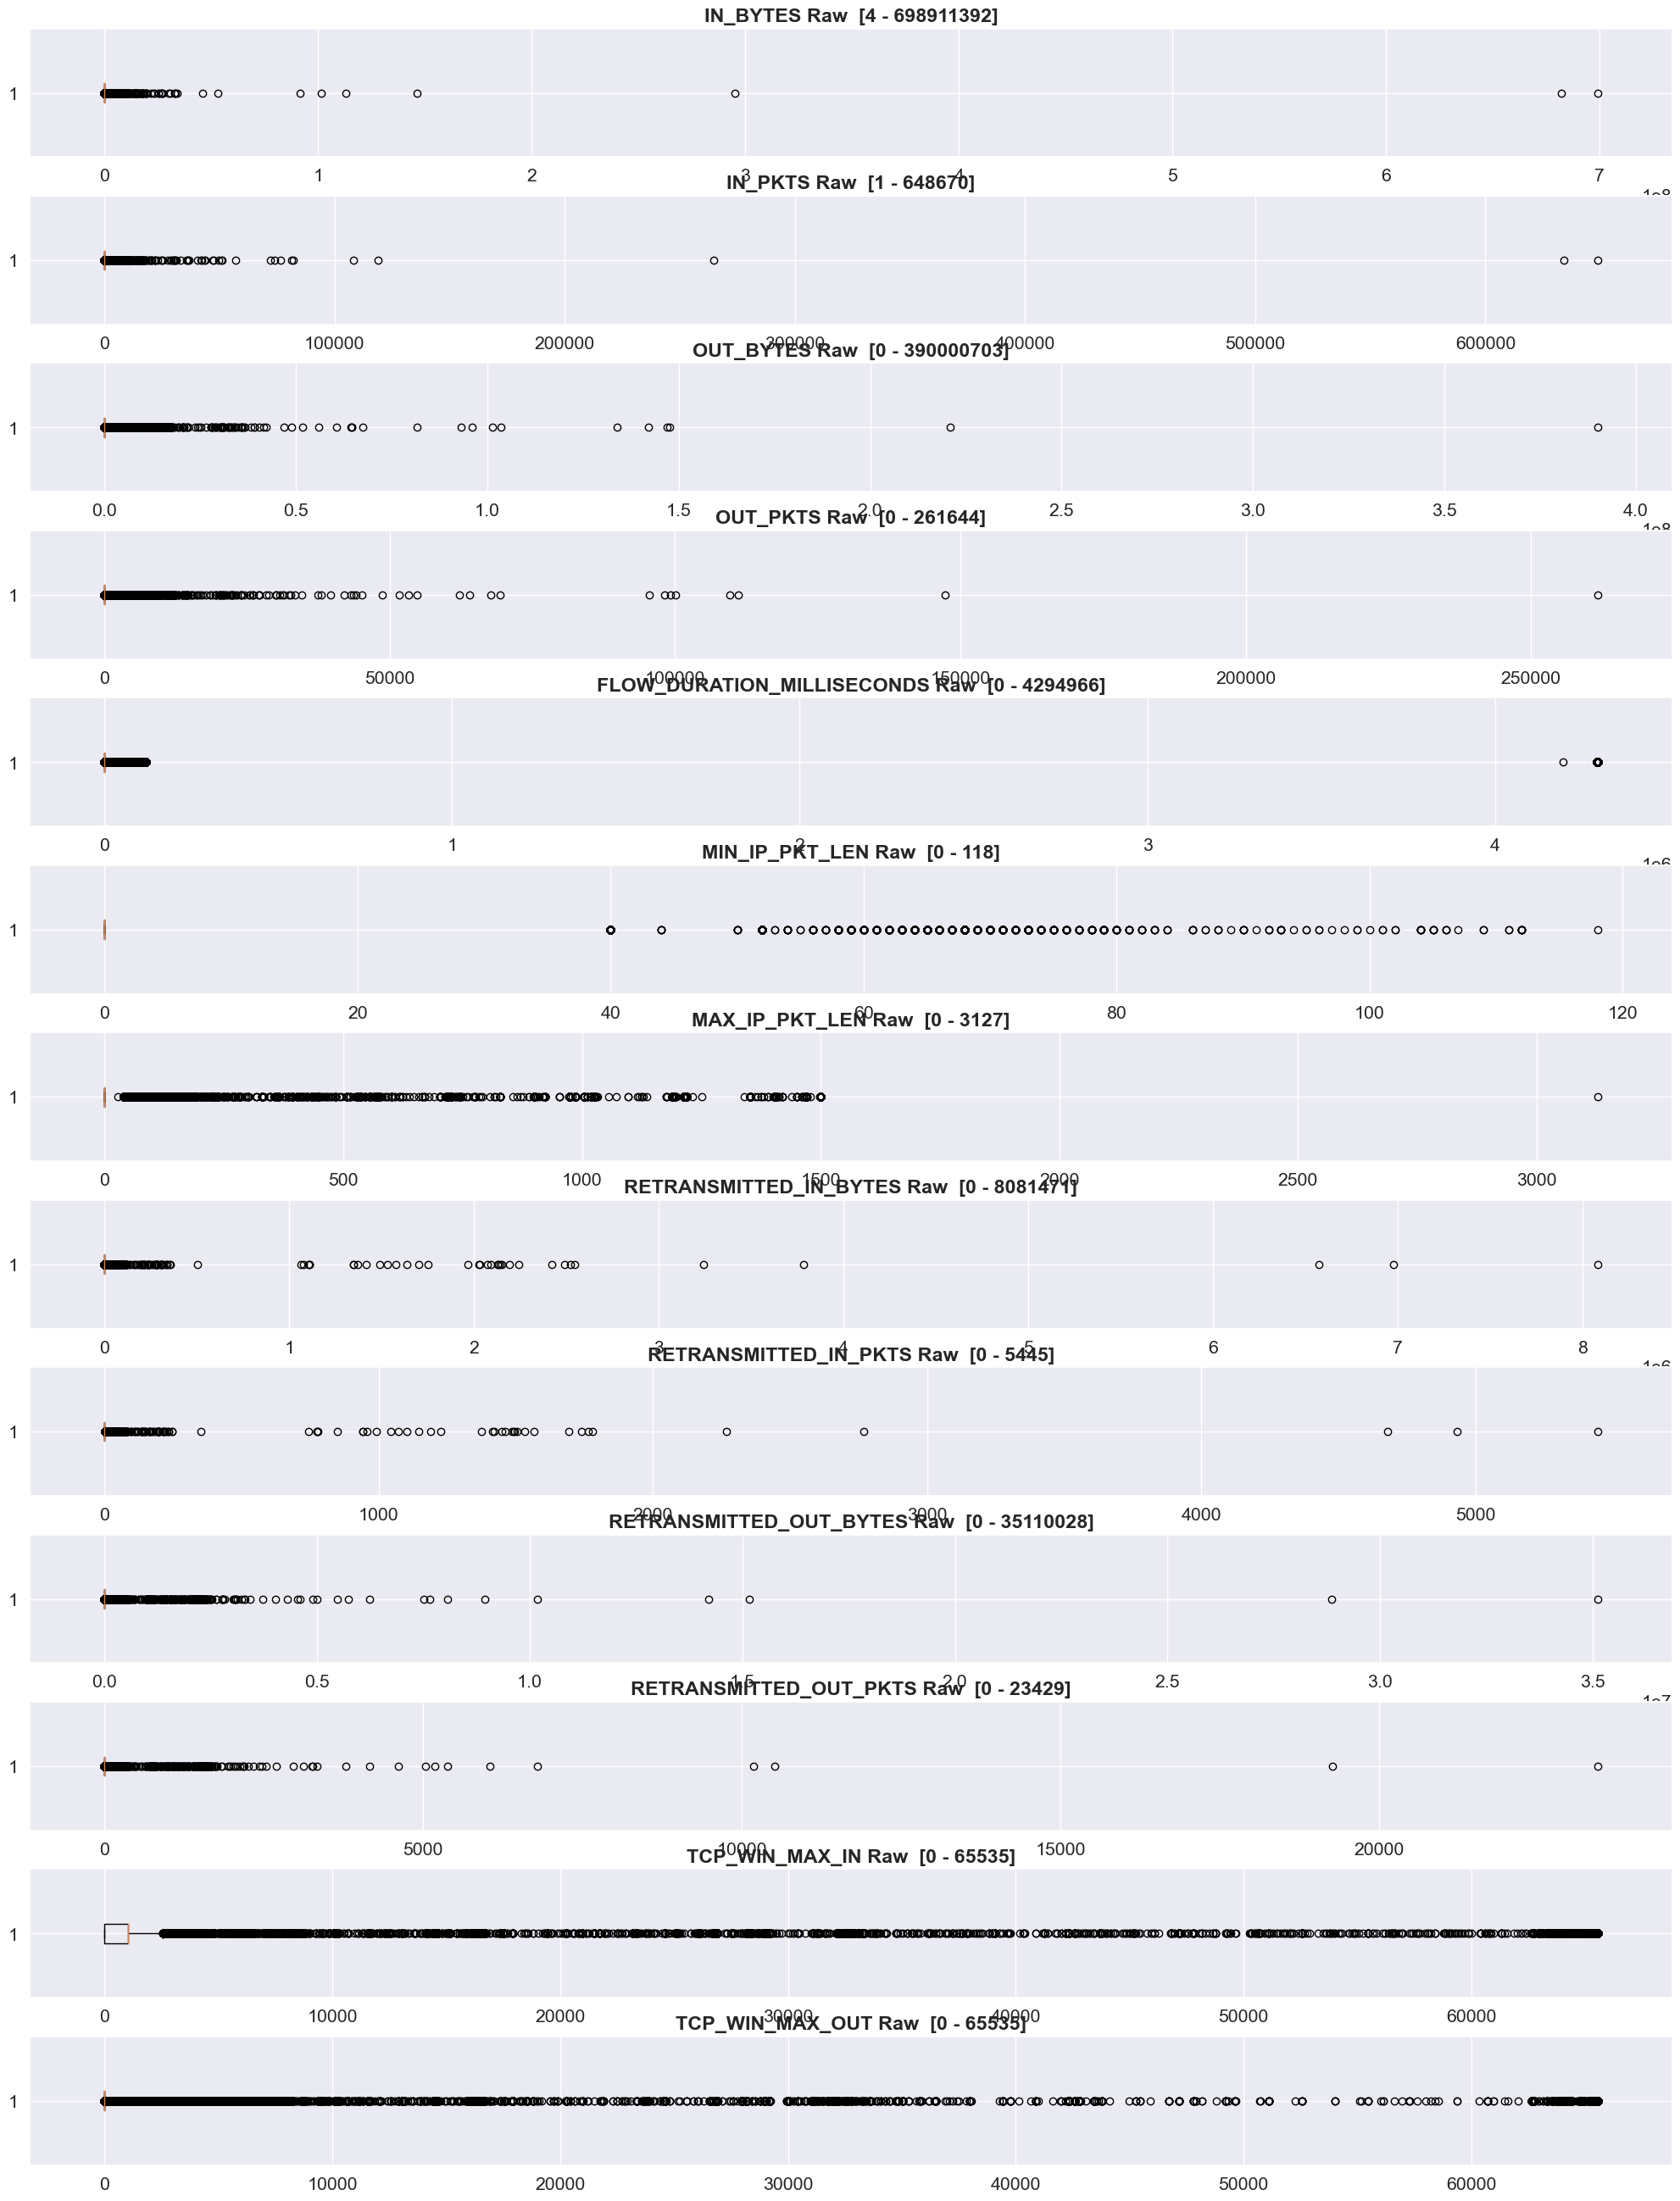

In [159]:
cols = ["IN_BYTES","IN_PKTS","OUT_BYTES","OUT_PKTS","FLOW_DURATION_MILLISECONDS","MIN_IP_PKT_LEN","MAX_IP_PKT_LEN","RETRANSMITTED_IN_BYTES","RETRANSMITTED_IN_PKTS","RETRANSMITTED_OUT_BYTES","RETRANSMITTED_OUT_PKTS","TCP_WIN_MAX_IN","TCP_WIN_MAX_OUT"]
fig_nr_columns = 1
fig_nr_rows = 17
fig = plt.figure(1, figsize=[25,43])

for k in range(len(cols)):
    num_bins = 100
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    ax = fig.add_subplot(fig_nr_rows, fig_nr_columns, k+1)
    yvalues = np.array(df[cols[k]].dropna())
    ax.boxplot(yvalues, vert=False)
    plt.title("{} Raw  [{} - {}]".format(cols[k], yvalues.min(), yvalues.max()), fontweight='bold')
plt.show()

Since the data is very skewed to the left, we'll apply the log transform.

In [82]:
out_cols = ["IN_BYTES","IN_PKTS","OUT_BYTES","OUT_PKTS","FLOW_DURATION_MILLISECONDS","MIN_IP_PKT_LEN","MAX_IP_PKT_LEN","RETRANSMITTED_IN_BYTES","RETRANSMITTED_IN_PKTS","RETRANSMITTED_OUT_BYTES","RETRANSMITTED_OUT_PKTS","TCP_WIN_MAX_IN","TCP_WIN_MAX_OUT"]

df[out_cols] = np.log(df[out_cols] + 1)

In [138]:
from sklearn.preprocessing import StandardScaler

out_cols = ["IN_BYTES","IN_PKTS","OUT_BYTES","OUT_PKTS","FLOW_DURATION_MILLISECONDS","MIN_IP_PKT_LEN","MAX_IP_PKT_LEN","RETRANSMITTED_IN_BYTES","RETRANSMITTED_IN_PKTS","RETRANSMITTED_OUT_BYTES","RETRANSMITTED_OUT_PKTS","TCP_WIN_MAX_IN","TCP_WIN_MAX_OUT"]
scaler = StandardScaler()
df[out_cols] = scaler.fit_transform(df[out_cols])
df[out_cols] = np.log(df[out_cols] + 1)


In [148]:
# Piora a performance do modelo

out_cols = ["IN_BYTES","IN_PKTS","OUT_BYTES","OUT_PKTS","FLOW_DURATION_MILLISECONDS","MIN_IP_PKT_LEN","MAX_IP_PKT_LEN","RETRANSMITTED_IN_BYTES","RETRANSMITTED_IN_PKTS","RETRANSMITTED_OUT_BYTES","RETRANSMITTED_OUT_PKTS","TCP_WIN_MAX_IN","TCP_WIN_MAX_OUT"]

def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

def impute_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   upper = df[~(df>(q3+1.5*IQR))].max()
   lower = df[~(df<(q1-1.5*IQR))].min()

   df = np.where(df > upper,
       df.mean(),
       np.where(
           df < lower,
           df.mean(),
           df
           )
       )

   return df

df[out_cols] = impute_outliers_IQR(df[out_cols])



## Best features selection
### SelectKBest

In [84]:
kbest = SelectKBest(chi2, k=6)
X_new = kbest.fit_transform(df.drop(['Label', 'Attack', 'PROTOCOL_MAP', 'AttackEnc'], axis=1), df.Label)
kbest.get_feature_names_out()

array(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'DST_TO_SRC_SECOND_BYTES_MEAN',
       'DST_TO_SRC_SECOND_BYTES_TOTAL', 'SRC_TO_DST_SECOND_BYTES_MEAN',
       'SRC_TO_DST_SECOND_BYTES_TOTAL'], dtype=object)

In [85]:
kbest = SelectKBest(chi2, k=6)
X_new = kbest.fit_transform(df.drop(['Label', 'Attack', 'PROTOCOL_MAP'], axis=1), df.AttackEnc)
kbest.get_feature_names_out()

array(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'DST_TO_SRC_SECOND_BYTES_MEAN',
       'DST_TO_SRC_SECOND_BYTES_TOTAL', 'SRC_TO_DST_SECOND_BYTES_MEAN',
       'SRC_TO_DST_SECOND_BYTES_TOTAL'], dtype=object)

### Feature importance
#### Label

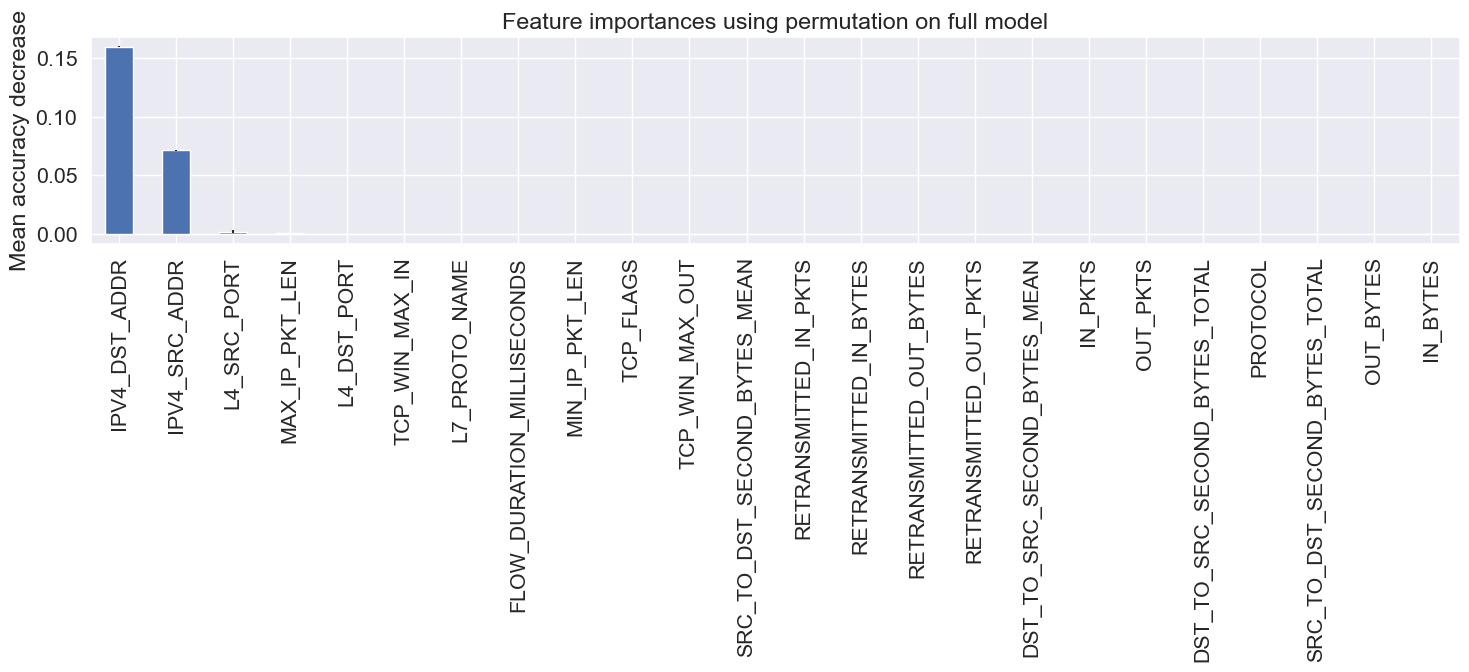

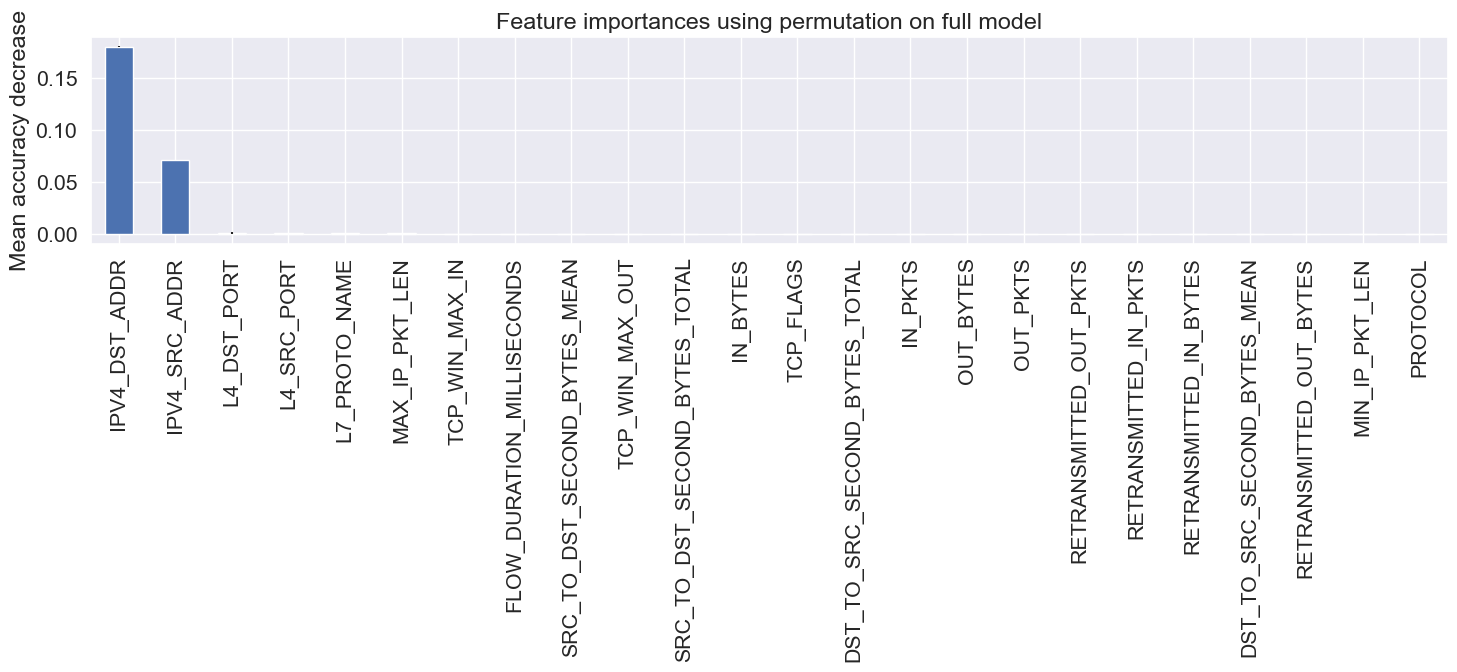

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

nums = df.select_dtypes(include=np.number)

X = nums.drop(columns=['Label', 'AttackEnc'], axis=1)
y = nums.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

forest = RandomForestClassifier(random_state=2022)
forest.fit(X_train, y_train)

result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=2022, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15, 7))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()



X = nums.drop(columns=['Label', 'AttackEnc'], axis=1)
y = nums.AttackEnc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

forest = RandomForestClassifier(random_state=2022)
forest.fit(X_train, y_train)

result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=2022, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15, 7))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### Model training
#### Full dataset - Label

In [87]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, mean_absolute_error

nums = df.select_dtypes(include=np.number)

X = nums.drop(columns=['Label', 'AttackEnc'], axis=1)
y = nums.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

model_full_label = RandomForestClassifier(random_state=2022)
model_full_label.fit(X_train, y_train)

full_label_train = f1_score(y_train, model_full_label.predict(X_train), average='macro')
full_label_test = f1_score(y_test, model_full_label.predict(X_test), average='macro')

print("TRAIN F1-SCORE:", full_label_train)
print("TEST F1-SCORE:", full_label_test)

TRAIN F1-SCORE: 0.9999979069473792
TEST F1-SCORE: 0.9997404505890194


#### Full dataset - Attack

In [88]:
from sklearn.metrics import f1_score

nums = df.select_dtypes(include=np.number)

X = nums.drop(columns=['Label', 'AttackEnc'], axis=1)
y = nums.AttackEnc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

model_full_attack = RandomForestClassifier(random_state=2022)
model_full_attack.fit(X_train, y_train)

full_attack_train = f1_score(y_train, model_full_attack.predict(X_train), average='macro')
full_attack_test = f1_score(y_test, model_full_attack.predict(X_test), average='macro')

print("TRAIN F1-SCORE:", full_attack_train)
print("TEST F1-SCORE:", full_attack_test)


TRAIN F1-SCORE: 0.9980320966380807
TEST F1-SCORE: 0.9119833145539044


#### 6 KBest features - Label

In [89]:
from sklearn.metrics import f1_score

nums = df.select_dtypes(include=np.number)

X = nums[['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'DST_TO_SRC_SECOND_BYTES_MEAN',
       'DST_TO_SRC_SECOND_BYTES_TOTAL', 'SRC_TO_DST_SECOND_BYTES_MEAN',
       'SRC_TO_DST_SECOND_BYTES_TOTAL']]
y = nums.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

model_6kbest_label = RandomForestClassifier(random_state=2022)
model_6kbest_label.fit(X_train, y_train)

kbest6_label_train = f1_score(y_train, model_6kbest_label.predict(X_train), average='macro')
kbest6_label_test = f1_score(y_test, model_6kbest_label.predict(X_test), average='macro')

print("TRAIN F1-SCORE:", kbest6_label_train)
print("TEST F1-SCORE:", kbest6_label_test)


TRAIN F1-SCORE: 0.9998681376170515
TEST F1-SCORE: 0.999757195585411


#### 6 KBest Features - Attack

In [90]:
from sklearn.metrics import f1_score

nums = df.select_dtypes(include=np.number)

X = nums[['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'DST_TO_SRC_SECOND_BYTES_MEAN',
       'DST_TO_SRC_SECOND_BYTES_TOTAL', 'SRC_TO_DST_SECOND_BYTES_MEAN',
       'SRC_TO_DST_SECOND_BYTES_TOTAL']]
y = nums.AttackEnc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

model_6kbest_attack = RandomForestClassifier(random_state=2022)
model_6kbest_attack.fit(X_train, y_train)

kbest6_attack_train = f1_score(y_train, model_6kbest_attack.predict(X_train), average='macro')
kbest6_attack_test = f1_score(y_test, model_6kbest_attack.predict(X_test), average='macro')

print("TRAIN F1-SCORE:", kbest6_attack_train)
print("TEST F1-SCORE:", kbest6_attack_test)


TRAIN F1-SCORE: 0.8789693397577176
TEST F1-SCORE: 0.7647069147363599


#### Best Feature importance - Label

In [91]:
from sklearn.metrics import f1_score

nums = df.select_dtypes(include=np.number)

X = nums[['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'L4_SRC_PORT', 'MAX_IP_PKT_LEN', 'L4_DST_PORT', 'TCP_WIN_MAX_IN']]
y = nums.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

model_feat_importance_label = RandomForestClassifier(random_state=2022)
model_feat_importance_label.fit(X_train, y_train)

feat_importance_label_train = f1_score(y_train, model_feat_importance_label.predict(X_train), average='macro')
feat_importance_label_test = f1_score(y_test, model_feat_importance_label.predict(X_test), average='macro')

print("TRAIN F1-SCORE:", feat_importance_label_train)
print("TEST F1-SCORE:", feat_importance_label_test)


TRAIN F1-SCORE: 0.9999979069473792
TEST F1-SCORE: 0.9998158036678224


#### Best Feature importance - Attack

In [92]:
from sklearn.metrics import f1_score

nums = df.select_dtypes(include=np.number)

X = nums[['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'L4_SRC_PORT', 'MAX_IP_PKT_LEN', 'L4_DST_PORT', 'L7_PROTO_NAME']]
y = nums.AttackEnc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

model_6kbest_attack = RandomForestClassifier(random_state=2022)
model_6kbest_attack.fit(X_train, y_train)

feat_importance_attack_train = f1_score(y_train, model_6kbest_attack.predict(X_train), average='macro')
feat_importance_attack_test = f1_score(y_test, model_6kbest_attack.predict(X_test), average='macro')

print("TRAIN F1-SCORE:", feat_importance_attack_train)
print("TEST F1-SCORE:", feat_importance_attack_test)


TRAIN F1-SCORE: 0.9959644990650501
TEST F1-SCORE: 0.7405331819125612


              type     score    set
0             full  0.999998  train
1             full  0.999740   test
2           kbest6  0.999868  train
3           kbest6  0.999757   test
4  feat_importance  0.999998  train
5  feat_importance  0.999816   test


<AxesSubplot:xlabel='type', ylabel='score'>

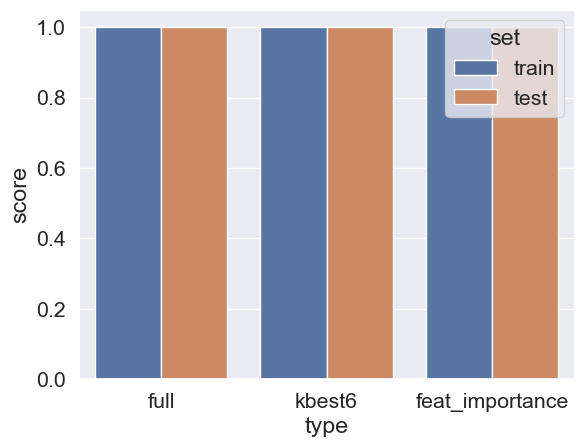

In [93]:
results_data_label = [
    { 'type': 'full', 'score': full_label_train, 'set': 'train' },
    { 'type': 'full', 'score': full_label_test, 'set': 'test' },
    { 'type': 'kbest6', 'score': kbest6_label_train, 'set': 'train' },
    { 'type': 'kbest6', 'score': kbest6_label_test, 'set': 'test' },
    { 'type': 'feat_importance', 'score': feat_importance_label_train, 'set': 'train' },
    { 'type': 'feat_importance', 'score': feat_importance_label_test, 'set': 'test' },
]

label_data = pd.DataFrame(results_data_label)
print(label_data)

sns.barplot(data=label_data, x="type", y="score", hue="set")

              type     score    set
0             full  0.998032  train
1             full  0.911983   test
2           kbest6  0.878969  train
3           kbest6  0.764707   test
4  feat_importance  0.995964  train
5  feat_importance  0.740533   test


<AxesSubplot:xlabel='type', ylabel='score'>

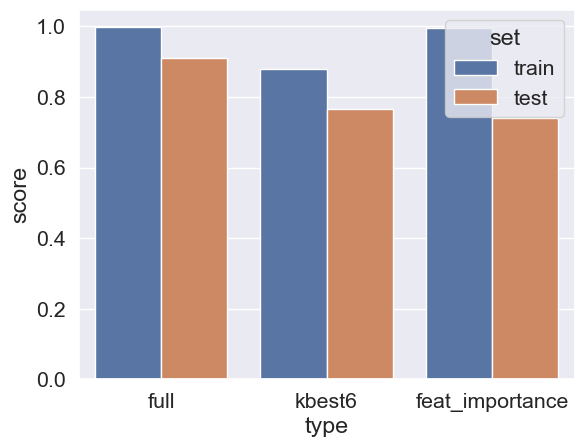

In [94]:
results_data_attack = [
    { 'type': 'full', 'score': full_attack_train, 'set': 'train' },
    { 'type': 'full', 'score': full_attack_test, 'set': 'test' },
    { 'type': 'kbest6', 'score': kbest6_attack_train, 'set': 'train' },
    { 'type': 'kbest6', 'score': kbest6_attack_test, 'set': 'test' },
    { 'type': 'feat_importance', 'score': feat_importance_attack_train, 'set': 'train' },
    { 'type': 'feat_importance', 'score': feat_importance_attack_test, 'set': 'test' },
]

attack_data = pd.DataFrame(results_data_attack)
print(attack_data)

sns.barplot(data=attack_data, x="type", y="score", hue="set")

In [101]:
forest_importances.index

Index(['IPV4_DST_ADDR', 'IPV4_SRC_ADDR', 'L4_DST_PORT', 'L4_SRC_PORT',
       'L7_PROTO_NAME', 'MAX_IP_PKT_LEN', 'TCP_WIN_MAX_IN',
       'FLOW_DURATION_MILLISECONDS', 'SRC_TO_DST_SECOND_BYTES_MEAN',
       'TCP_WIN_MAX_OUT', 'SRC_TO_DST_SECOND_BYTES_TOTAL', 'IN_BYTES',
       'TCP_FLAGS', 'DST_TO_SRC_SECOND_BYTES_TOTAL', 'IN_PKTS', 'OUT_BYTES',
       'OUT_PKTS', 'RETRANSMITTED_OUT_PKTS', 'RETRANSMITTED_IN_PKTS',
       'RETRANSMITTED_IN_BYTES', 'DST_TO_SRC_SECOND_BYTES_MEAN',
       'RETRANSMITTED_OUT_BYTES', 'MIN_IP_PKT_LEN', 'PROTOCOL'],
      dtype='object')

In [103]:
available_cols = list(forest_importances.index)
cols = []
data = []

for col in available_cols:
    cols.append(col)

    X = df[cols]
    y = df.AttackEnc
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

    model = RandomForestClassifier(random_state=2022)
    model.fit(X_train, y_train)

    score_train = f1_score(y_train, model.predict(X_train), average='macro')
    score_test = f1_score(y_test, model.predict(X_test), average='macro')
    cols_str = ','.join(cols)
    data.append({
        'n_cols': len(cols),
        'score': score_train,
        'set': 'train',
        'cols': cols_str
    })
    data.append({
        'n_cols':len(cols),
        'score': score_test,
        'set': 'test',
        'cols': cols_str
    })

    print(cols)
    print("TRAIN F1-SCORE:", score_train)
    print("TEST F1-SCORE:", score_test)
    print("\n")
    

['IPV4_DST_ADDR']
TRAIN F1-SCORE: 0.9959644990650501
TEST F1-SCORE: 0.7405331819125612


['IPV4_DST_ADDR', 'IPV4_SRC_ADDR']
TRAIN F1-SCORE: 0.9959644990650501
TEST F1-SCORE: 0.7405331819125612


['IPV4_DST_ADDR', 'IPV4_SRC_ADDR', 'L4_DST_PORT']
TRAIN F1-SCORE: 0.9959644990650501
TEST F1-SCORE: 0.7405331819125612


['IPV4_DST_ADDR', 'IPV4_SRC_ADDR', 'L4_DST_PORT', 'L4_SRC_PORT']
TRAIN F1-SCORE: 0.9959644990650501
TEST F1-SCORE: 0.7405331819125612


['IPV4_DST_ADDR', 'IPV4_SRC_ADDR', 'L4_DST_PORT', 'L4_SRC_PORT', 'L7_PROTO_NAME']
TRAIN F1-SCORE: 0.9959644990650501
TEST F1-SCORE: 0.7405331819125612


['IPV4_DST_ADDR', 'IPV4_SRC_ADDR', 'L4_DST_PORT', 'L4_SRC_PORT', 'L7_PROTO_NAME', 'MAX_IP_PKT_LEN']
TRAIN F1-SCORE: 0.9959644990650501
TEST F1-SCORE: 0.7405331819125612


['IPV4_DST_ADDR', 'IPV4_SRC_ADDR', 'L4_DST_PORT', 'L4_SRC_PORT', 'L7_PROTO_NAME', 'MAX_IP_PKT_LEN', 'TCP_WIN_MAX_IN']
TRAIN F1-SCORE: 0.9959644990650501
TEST F1-SCORE: 0.7405331819125612


['IPV4_DST_ADDR', 'IPV4_SRC_ADDR', 

<AxesSubplot:xlabel='n_cols', ylabel='score'>

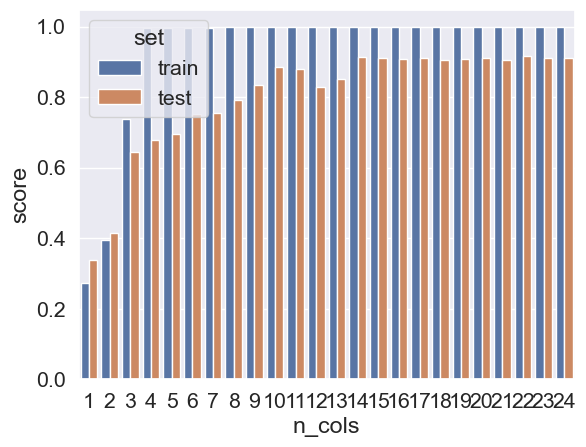

In [109]:
data_pd = pd.DataFrame(data)
sns.barplot(data=data_pd, x="n_cols", y="score", hue="set")

In [115]:
data_pd[data_pd.n_cols == 7].cols.values


array(['IPV4_DST_ADDR,IPV4_SRC_ADDR,L4_DST_PORT,L4_SRC_PORT,L7_PROTO_NAME,MAX_IP_PKT_LEN,TCP_WIN_MAX_IN',
       'IPV4_DST_ADDR,IPV4_SRC_ADDR,L4_DST_PORT,L4_SRC_PORT,L7_PROTO_NAME,MAX_IP_PKT_LEN,TCP_WIN_MAX_IN'],
      dtype=object)

In [114]:
data_pd[data_pd.n_cols == 14].cols.values

array(['IPV4_DST_ADDR,IPV4_SRC_ADDR,L4_DST_PORT,L4_SRC_PORT,L7_PROTO_NAME,MAX_IP_PKT_LEN,TCP_WIN_MAX_IN,FLOW_DURATION_MILLISECONDS,SRC_TO_DST_SECOND_BYTES_MEAN,TCP_WIN_MAX_OUT,SRC_TO_DST_SECOND_BYTES_TOTAL,IN_BYTES,TCP_FLAGS,DST_TO_SRC_SECOND_BYTES_TOTAL',
       'IPV4_DST_ADDR,IPV4_SRC_ADDR,L4_DST_PORT,L4_SRC_PORT,L7_PROTO_NAME,MAX_IP_PKT_LEN,TCP_WIN_MAX_IN,FLOW_DURATION_MILLISECONDS,SRC_TO_DST_SECOND_BYTES_MEAN,TCP_WIN_MAX_OUT,SRC_TO_DST_SECOND_BYTES_TOTAL,IN_BYTES,TCP_FLAGS,DST_TO_SRC_SECOND_BYTES_TOTAL'],
      dtype=object)

In [117]:
cols

['IPV4_DST_ADDR',
 'IPV4_SRC_ADDR',
 'L4_DST_PORT',
 'L4_SRC_PORT',
 'L7_PROTO_NAME',
 'MAX_IP_PKT_LEN',
 'FLOW_DURATION_MILLISECONDS',
 'SRC_TO_DST_SECOND_BYTES_MEAN',
 'TCP_WIN_MAX_OUT',
 'SRC_TO_DST_SECOND_BYTES_TOTAL',
 'IN_BYTES',
 'TCP_FLAGS',
 'DST_TO_SRC_SECOND_BYTES_TOTAL']

In [160]:
from sklearn.metrics import f1_score

nums = df.select_dtypes(include=np.number)

cols = 'IPV4_DST_ADDR,IPV4_SRC_ADDR,L4_DST_PORT,L4_SRC_PORT,L7_PROTO_NAME,MAX_IP_PKT_LEN,FLOW_DURATION_MILLISECONDS,SRC_TO_DST_SECOND_BYTES_MEAN,TCP_WIN_MAX_OUT,SRC_TO_DST_SECOND_BYTES_TOTAL,IN_BYTES,TCP_FLAGS,DST_TO_SRC_SECOND_BYTES_TOTAL'
cols = cols.split(',')

X = nums[cols]
y = nums.AttackEnc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

model = RandomForestClassifier(random_state=2022)
model.fit(X_train, y_train)

score_train = f1_score(y_train, model.predict(X_train), average='macro')
score_test = f1_score(y_test, model.predict(X_test), average='macro')

print("TRAIN F1-SCORE:", score_train)
print("TEST F1-SCORE:", score_test)
cols

TRAIN F1-SCORE: 0.9980320966380807
TEST F1-SCORE: 0.9086031495198077


['IPV4_DST_ADDR',
 'IPV4_SRC_ADDR',
 'L4_DST_PORT',
 'L4_SRC_PORT',
 'L7_PROTO_NAME',
 'MAX_IP_PKT_LEN',
 'FLOW_DURATION_MILLISECONDS',
 'SRC_TO_DST_SECOND_BYTES_MEAN',
 'TCP_WIN_MAX_OUT',
 'SRC_TO_DST_SECOND_BYTES_TOTAL',
 'IN_BYTES',
 'TCP_FLAGS',
 'DST_TO_SRC_SECOND_BYTES_TOTAL']